# Forecasting data from magnetometer stations with Prophet library.

## Data download.

In [ ]:
!pip install gdown==4.6.4

In [ ]:
import gdown
requirements_url = 'https://drive.google.com/drive/folders/1RlVel5j8hW9Gxnr0SNQZTMJVvpQbbRLv?usp=share_link'
# Main data.
data_url         = 'https://drive.google.com/drive/folders/1Pf0soKlFy21_9VADQ4hvjbMeevTdjuOW?usp=share_link'
# Data for additional regressors.
extra_data_url   = 'https://drive.google.com/drive/folders/1zHEqOts2wlUHguE4HsxIvvgkFO0OB2a4?usp=share_link'

links = [requirements_url, data_url, extra_data_url]

# Downloading data.
for url in links:
    gdown.download_folder(url, quiet=True)

In [ ]:
!pip install -r /content/requirements/requirements.txt

## Import necessary libraries and set up the environment.

In [ ]:
import prophet
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.offline as py
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

from tqdm import tqdm

from sklearn.impute import KNNImputer

Disable logger outputs from Prophet and cmdstanpy:

In [ ]:
import logging

logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

logging.getLogger('prophet').setLevel(logging.WARNING)

## Data processing and review.

In [ ]:
d = pd.read_csv("/content/data.text", sep='\s+', na_values=99999.9)
d.head()

,YYYY,MM,DD,HH,MM.1,SS,KEV_X,KEV_Y,KEV_Z
0,1983,1,4,1,0,0,NaN,NaN,NaN
1,1983,1,4,2,0,0,NaN,NaN,NaN
2,1983,1,4,3,0,0,NaN,NaN,NaN
3,1983,1,4,4,0,0,NaN,NaN,NaN
4,1983,1,4,5,0,0,NaN,NaN,NaN


In [ ]:
original_df = pd.read_csv("/content/data/data.csv", na_values=99999.9)[['date','KEV_X']]
original_df.head()

,date,KEV_X
0,1984-03-27-00-00-00,11003.5
1,1984-03-27-01-00-00,11035.9
2,1984-03-27-02-00-00,11120.7
3,1984-03-27-03-00-00,11150.7
4,1984-03-27-04-00-00,11143.3


In [ ]:
original_df.tail()

,date,KEV_X
341995,2023-04-01-19-00-00,NaN
341996,2023-04-01-20-00-00,NaN
341997,2023-04-01-21-00-00,NaN
341998,2023-04-01-22-00-00,NaN
341999,2023-04-01-23-00-00,NaN


Convert data to a format convenient for the Prophet library:

In [ ]:
df = original_df.rename(columns={'date': 'ds',
                                'KEV_X': 'y'})
df.ds = pd.to_datetime(df.ds, format='%Y-%m-%d-%H-%M-%S')
df.head()

,ds,y
0,1984-03-27 00:00:00,11003.5
1,1984-03-27 01:00:00,11035.9
2,1984-03-27 02:00:00,11120.7
3,1984-03-27 03:00:00,11150.7
4,1984-03-27 04:00:00,11143.3


What raw time series data looks like.

Due to the fact that the data before 2003 are not of very good quality, we will not use them for forecasting.

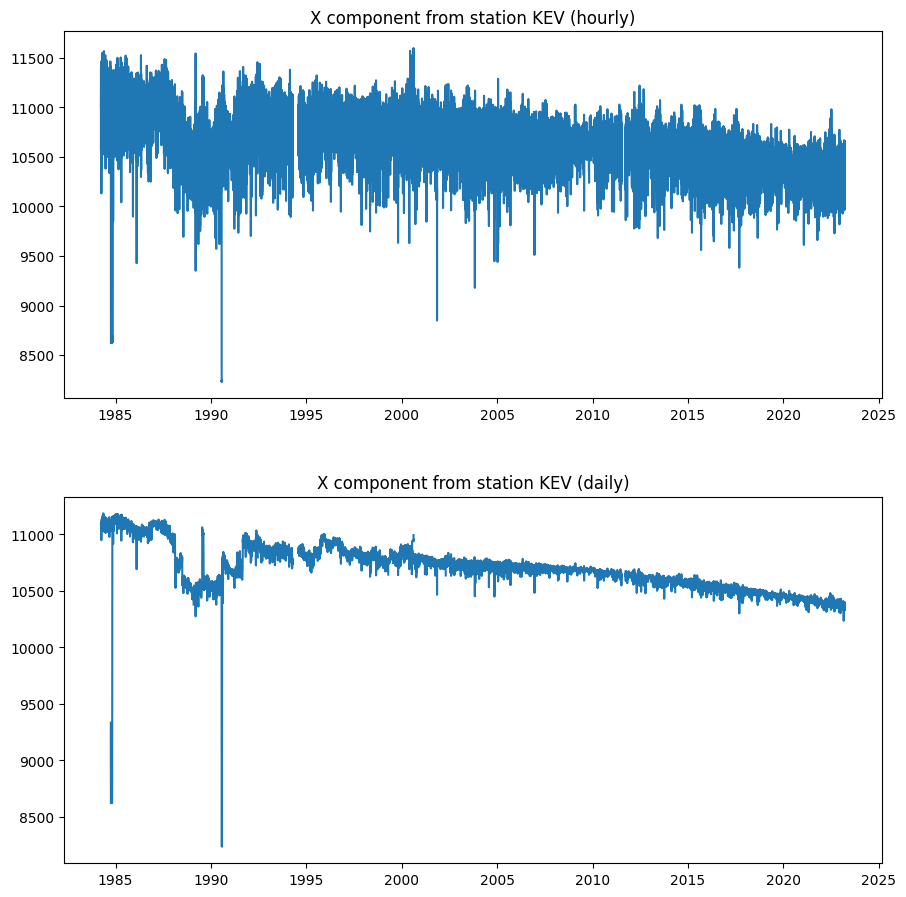

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
ax1.plot(df.ds, df.y)
ax1.set_title('X component from station KEV (hourly)')
ax2.plot(df.resample('1D', on='ds').mean().reset_index().ds, df.resample('1D', on='ds').mean().y)
ax2.set_title('X component from station KEV (daily)')
plt.show()

Let's look at the additional regressors:

year,day,hr,min,sec: year, day of year, hour of day, minutes, seconds.<br>
Br            : R-component of mag. field in RTN (nT).<br>
Bt            : T-component of mag. field in RTN (nT).<br>
Bn            : N-component of mag. field in RTN (nT).<br>
Bmag          : <|B|> magnetic field magnitude (nT).<br>
Delta         : RTN latitude.<br>
Lambda        : RTN longitude.<br>
Bgse_x        : X-component of mag. field in GSE (nT).<br>
Bgse_y        : Y-component of mag. field in GSE (nT).<br>
Bgse_z        : Z-component of mag. field in GSE (nT).<br>
Bgsm_x        : X-component of mag. field in GSM (nT).<br>
Bgsm_y        : Y-component of mag. field in GSM (nT).<br>
Bgsm_z        : Z-component of mag. field in GSM (nT).<br>
dBrms         : RMS values of underlying high-resolution measurements (nT).<br>
sigma_B       : Variance of |B|, i.e. sqrt(<(|B|-<|B|>)^2>) (nT).<br>
pos_gse_x,y,z : Components of spacecraft position in GSE (km).<br>
pos_gsm_x,y,z : Components of spacecraft position in GSM (km).<br>
A value of -999.9 indicates bad or missing data.<br>
Link to dataset: https://izw1.caltech.edu/ACE/ASC/level2/lvl2DATA_MAG.html

In [ ]:
additional_df = pd.read_csv('/content/AdditionalData/ASCyv6iXk.txt', sep='\s+', na_values=[-999.9])

In [ ]:
additional_df.head()

,year,day,hr,min,sec,Br,Bn,Bmag,Delta,Lambda,...,Bgsm_y,Bgsm_z,dBrms,sigma_B,pos_gse_x,pos_gse_y,pos_gse_z,pos_gsm_x,pos_gsm_y,pos_gsm_z
0,1997,226,0,0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1542000.0,-229970.0,148940.0,1542000.0,-204150.0,182740.0
1,1997,226,1,0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1542000.0,-229970.0,148940.0,1542000.0,-199060.0,188270.0
2,1997,226,2,0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1542000.0,-229970.0,148940.0,1542000.0,-192060.0,195410.0
3,1997,226,3,0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1542000.0,-229970.0,148940.0,1542000.0,-183430.0,203530.0
4,1997,226,4,0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1542000.0,-229970.0,148940.0,1542000.0,-173610.0,211970.0


In [ ]:
def create_date(year, day, hr):
  return (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(day) - 1)).replace(hour=int(hr))
additional_df.insert(0, 'date', additional_df.apply(lambda x: create_date(x.year, x.day, x.hr), axis=1))

Combining a Time Series with additional regressor data:

In [ ]:
additional_df.drop(columns=['year', 'day', 'hr', 'min', 'sec'], inplace=True)
additional_df.rename(columns={"date": "ds"}, inplace=True)
additional_df = additional_df[additional_df.ds > datetime.datetime.strptime('2003-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')].reset_index(drop=True)
df = df[df.ds > datetime.datetime.strptime('2003-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')].reset_index(drop=True)
additional_df = additional_df[additional_df.ds <= datetime.datetime.strptime('2023-04-01 23:00:00', '%Y-%m-%d %H:%M:%S')].reset_index(drop=True)
df = df.merge(additional_df, left_on=['ds'], right_on=['ds'], how='outer')

In [ ]:
df.head()

,ds,y,Br,Bn,Bmag,Delta,Lambda,Bgse_x,Bgse_y,Bgse_z,...,Bgsm_y,Bgsm_z,dBrms,sigma_B,pos_gse_x,pos_gse_y,pos_gse_z,pos_gsm_x,pos_gsm_y,pos_gsm_z
0,2003-01-01 01:00:00,10758.1,0.479,-0.899,6.655,-9.426,275.070,-0.483,5.256,-1.513,...,5.451,-0.229,3.735,0.175,1543900.0,-76283.0,120490.0,1543900.0,-102500.0,99146.0
1,2003-01-01 02:00:00,10757.7,-0.070,-0.041,6.747,-0.445,269.247,0.067,5.305,-0.655,...,5.339,0.407,4.099,0.244,1543900.0,-76613.0,120610.0,1543900.0,-99065.0,102960.0
2,2003-01-01 03:00:00,10746.4,-2.663,2.769,7.175,23.305,245.517,2.662,6.130,2.076,...,5.749,2.977,1.549,0.143,1543800.0,-76943.0,120720.0,1543800.0,-94378.0,107640.0
3,2003-01-01 04:00:00,10752.3,-2.277,1.525,7.443,12.159,251.240,2.274,6.835,0.744,...,6.713,1.402,1.692,0.109,1543800.0,-77273.0,120840.0,1543800.0,-88726.0,112700.0
4,2003-01-01 05:00:00,10760.8,-0.641,-1.269,7.167,-10.986,264.375,0.636,6.315,-2.007,...,6.382,-1.732,2.638,0.298,1543800.0,-77602.0,120960.0,1543800.0,-82587.0,117610.0


Viz for some additional regressors:

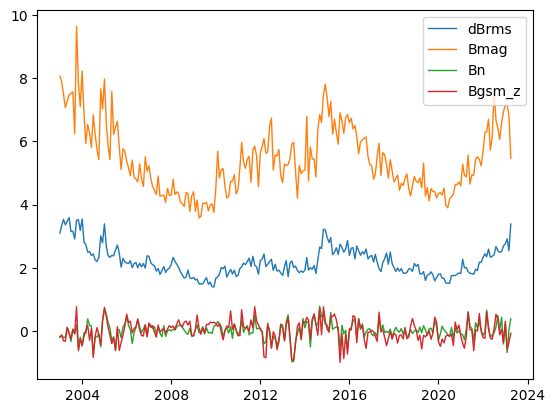

In [ ]:
plt.plot(df.resample('1MS', on='ds').mean().dBrms, label='dBrms', linewidth=1)
plt.plot(df.resample('1MS', on='ds').mean().Bmag, label='Bmag', linewidth=1)
plt.plot(df.resample('1MS', on='ds').mean().Bn, label='Bn', linewidth=1)
plt.plot(df.resample('1MS', on='ds').mean().Bgsm_z, label='Bgsm_z', linewidth=1)
plt.legend()
plt.show()

Train and test split:

In [ ]:
train_size = int(df.shape[0] * 0.8)

df_train = df[:train_size]
df_test = df[train_size:]

In [ ]:
def fill_missing_values(dataframe, method='mean'):
    dataframe = dataframe.copy(deep=True)
    # fill with mean.
    if method == 'mean':
        return dataframe.fillna(dataframe.mean(numeric_only=True).round(1))
    # fill with median.
    if method == 'median':
        return dataframe.fillna(dataframe.median(numeric_only=True).round(1))
    # filling occurs with previous values.
    # if there are nan left, fill with bfill.
    if method == 'ffill':
        return dataframe.fillna(method=method).fillna(method='bfill')
    # filling occurs with next values.
    # if there are nan left, fill with ffill.
    if method == 'bfill':
        return dataframe.fillna(method=method).fillna(method='ffill')
    # fill with backward interpolation.
    # if there are nan left, fill with forward.
    if method == 'interpolate_backward':
        return dataframe.apply(lambda col: col.interpolate(method ='linear', limit_direction ='backward')
                                              .interpolate(method ='linear', limit_direction ='forward') if col.name != "ds" else col)
    # fill with forward interpolation.
    # if there are nan left, fill with backward.
    if method == 'interpolate_forward':
        return dataframe.apply(lambda col: col.interpolate(method ='linear', limit_direction ='forward')
                                              .interpolate(method ='linear', limit_direction ='backward') if col.name != "ds" else col)
    # fill with knn method.
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=15)
        dataframe = dataframe.apply(lambda col: imputer.fit_transform(col.to_numpy().reshape(-1, 1)).T[0] if col.name != "ds" else col)
        return dataframe

    return dataframe

Find best method for filling missing values:

In [ ]:
methods = ['mean', 'median', 'ffill', 'bfill', 'interpolate_backward', 'interpolate_forward', 'knn']

mses = []
for method in tqdm(methods, position=0, leave=True):
    # replace nan values.
    no_nan_df = fill_missing_values(df_train, method)
    no_nan_df = no_nan_df.resample('1D', on='ds').mean()
    no_nan_df.reset_index(inplace=True)
    model = Prophet()
    model.fit(no_nan_df)

    model_cv = cross_validation(model, horizon="365 days", period="365 days", initial="1095 days", disable_tqdm=True)
    model_p = performance_metrics(model_cv, rolling_window=1)
    mses.append(model_p['mse'].values[0])

print(f"Best method: {methods[np.argmin(mses)]}")
fill_mv_results = pd.DataFrame({"methods": methods})
fill_mv_results['mse'] = mses
fill_mv_results.sort_values("mse").reset_index(drop=True)

100%|██████████| 7/7 [02:28<00:00, 21.21s/it]

Best method: bfill


,methods,mse
0,bfill,558.067714
1,median,572.796104
2,mean,595.543610
3,knn,596.033961
4,interpolate_backward,764.922715
5,interpolate_forward,764.922715
6,ffill,1123.738997


Fill missing values for train and test data:

In [ ]:
df_train = fill_missing_values(df_train, 'bfill')
df_test = fill_missing_values(df_test, 'bfill')
print("number of NaN values in train: ", df_train.isna().sum().sum())
print("number of NaN values in test:", df_test.isna().sum().sum())

number of NaN values in train:  0
number of NaN values in test: 0


In [ ]:
def plot_train_and_test(train, test):
    plt.figure(figsize=(10,5))

    plt.plot(train.index, train.y, color='b', label='train', linewidth=0.5)
    plt.plot(test.index, test.y, color='r', label='test', linewidth=0.5)

    plt.xlabel("Date", fontsize=14)
    plt.ylabel("KEV_X")
    plt.title("Train and test data", fontsize=14)

    plt.legend()

    plt.show()

Let's look on how data looks like before dropping outliers:

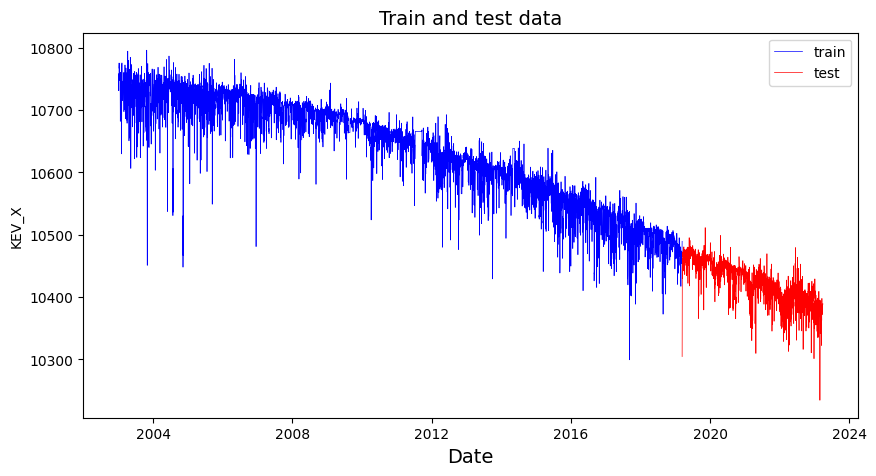

In [ ]:
df_train_with_outliers = df_train.copy(deep=True).resample('1D', on='ds').mean()
df_test_with_outliers = df_test.copy(deep=True).resample('1D', on='ds').mean()

plot_train_and_test(df_train_with_outliers, df_test_with_outliers);

Drop outliers:

In [ ]:
# Define the z-score function
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

# Calculate zscore with a rolling window and get abnormal values
window_size = 24
df_zscore = zscore(df_train, window_size)

# Apply a threshold for the z-score
threshold = 3
abnormal_values_dates = df_zscore[abs(df_zscore.y) > threshold ].index

<ipython-input-113-a3ab880c68ea>:4: FutureWarning:

Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['ds'], dtype='object')

<ipython-input-113-a3ab880c68ea>:5: FutureWarning:

Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['ds'], dtype='object')



In [ ]:
df_train.loc[abnormal_values_dates, 'y'] = np.nan

Resample time series from day to month:

In [ ]:
df_train = df_train.resample('1H', on='ds').mean()
df_test = df_test.resample('1H', on='ds').mean()

Visualize train and test data without outliers:

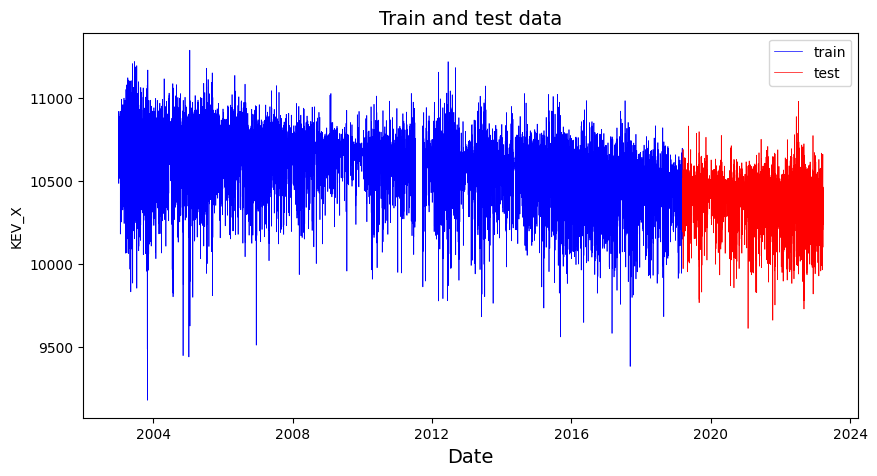

In [ ]:
plot_train_and_test(df_train, df_test);

## Model training.

In [ ]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [ ]:
df_train.shape

(142002, 21)

In [ ]:
mean_train = df_train.y.mean()
std_train = df_train.y.std()

mean_train, std_train

(10632.642060877299, 117.68984868763653)

In [ ]:
df_train.y = (df_train.y - mean_train) / std_train

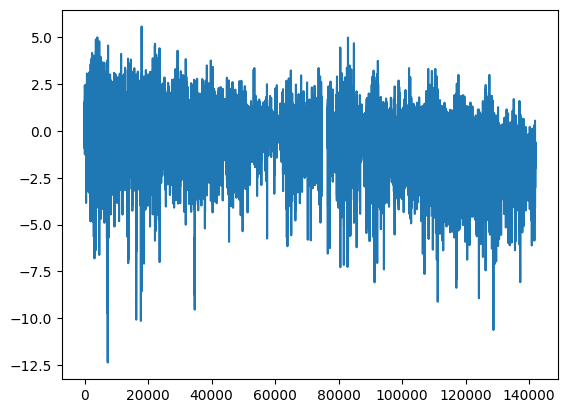

In [ ]:
plt.plot(df_train.y)

Let's look at baseline model performance:

In [ ]:
baseline_model = Prophet(changepoint_range=0.6, changepoint_prior_scale=0.002,	seasonality_prior_scale=10,	seasonality_mode='additive'	)
baseline_model.fit(df_train)

# baseline_model_cv = cross_validation(baseline_model, initial='1500 days', period='1000 days', horizon='1000 days', disable_tqdm=False)
# performance_metrics(baseline_model_cv, rolling_window=1)

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
df_test = df_test.ffill()
sum(df_test.y.isna())

0

In [ ]:
df_val = df_test[:15000]

r2 score: -0.640477726081724
mse: 0.21988355269537435
mape: 20.83971217279299
smape: 20.11863277131939


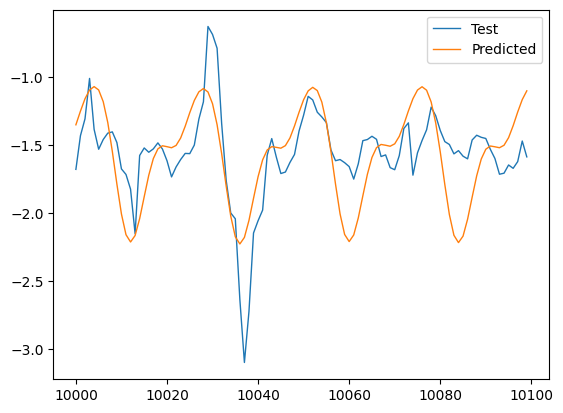

In [ ]:
future = df_val[['ds']]
forecast = baseline_model.predict(future)

predictions = forecast.iloc[-len(df_val):]['yhat']
actuals = df_val['y']

# predictions = (predictions - mean_train) / std_train
actuals = (actuals - mean_train) / std_train

print(f"r2 score: {r2_score(predictions, actuals)}")
print(f"mse: {mean_squared_error(predictions, actuals)}")
print(f"mape: {mean_absolute_percentage_error(predictions, actuals) * 100}")
print(f"smape: {smape(predictions, actuals)}")

plt.plot(actuals[-5000:-4900], label='Test', linewidth=1)
plt.plot(predictions[-5000:-4900], label='Predicted', linewidth=1)
plt.legend()
plt.show()
# r2 score: -0.6269513754831098
# mse: 0.21903890416647542
# mape: 20.328985490832967
# smape: 19.865840725178487

r2 score: 0.2736184124203498
mse: 526.2009060774429
mape: 0.0014551778794689915
smape: 0.1457171659224308


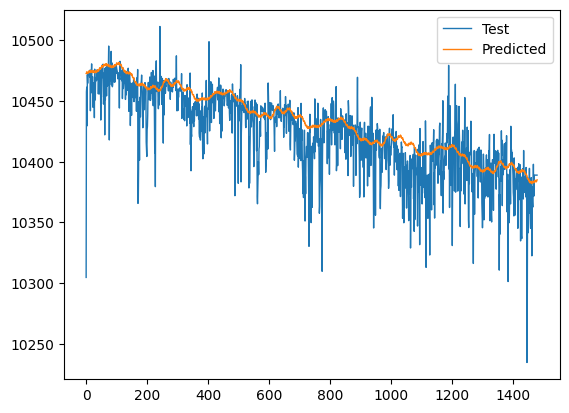

In [ ]:
baseline_model = Prophet(changepoint_range=0.6, changepoint_prior_scale=0.002,	seasonality_prior_scale=10,	seasonality_mode='additive'	)
baseline_model.fit(df_train)

future = df_test[['ds']]
forecast = baseline_model.predict(future)

predictions = forecast.iloc[-len(df_test):]['yhat']
actuals = df_test['y']
print(f"r2 score: {r2_score(predictions, actuals)}")
print(f"mse: {mean_squared_error(predictions, actuals)}")
print(f"mape: {mean_absolute_percentage_error(predictions, actuals)}")
print(f"smape: {smape(predictions, actuals)}")

plt.plot(actuals, label='Test', linewidth=1)
plt.plot(predictions, label='Predicted', linewidth=1)
plt.legend()
plt.show()

Let's look at model performance by changing chengepoint_range. The best model was with the default changepoint_range parameter (=0.8)

In [ ]:
mses = []
crs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for cr in tqdm(crs, position=0, leave=True):
    baseline_model = Prophet(changepoint_range=cr)
    baseline_model.fit(df_train)

    baseline_model_cv = cross_validation(baseline_model, initial='1095 days', period='365 days', horizon='365 days', disable_tqdm=True)
    baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
    mses.append(baseline_model_p['mse'].values[0])


print(f"Best changepoint_range: {crs[np.argmin(mses)]}")
chose_changepoint_range_results = pd.DataFrame({"changepoint_ranges": crs})
chose_changepoint_range_results['mse'] = mses
chose_changepoint_range_results.sort_values("mse").reset_index(drop=True)

100%|██████████| 9/9 [02:28<00:00, 16.51s/it]

Best changepoint_range: 0.6


,changepoint_ranges,mse
0,0.6,384.049963
1,0.5,388.772870
2,0.7,395.525827
3,0.4,405.802943
4,0.9,412.975311
5,0.8,432.902800
6,0.3,456.522257
7,0.2,540.955674
8,0.1,671.646170


Get all combinations from additional regressors:

In [ ]:
variables_list = ['Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B']

list_combinations = []
for i in range(len(variables_list) + 1):
    list_combinations += list(itertools.combinations(variables_list, i))
list_combinations[-10:]

[('Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z'),
 ('Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'sigma_B'),
 ('Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'dBrms', 'Delta', 'Bn', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'dBrms', 'Delta', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'dBrms', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B')]

Find best combination of additional regressors:

In [ ]:
%%time
mses = []
for combination in tqdm(list_combinations):
    m = Prophet(changepoint_range=0.9)
    for regressor in combination:
        m.add_regressor(regressor)
    m.fit(df_train)
    df_cv = cross_validation(m, horizon="365 days", period="365 days", initial="1095 days", disable_tqdm=True)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])

tuning_results = pd.DataFrame(list_combinations)
tuning_results['mse'] = mses
best_combination = list_combinations[np.argmin(mses)]
print(best_combination)
tuning_results.sort_values("mse").reset_index(drop=True).head(10)

  0%|          | 0/256 [00:03<?, ?it/s]


KeyboardInterrupt: ignored

Fit model with additional regressors:

In [ ]:
reg_model = Prophet(changepoint_range=0.9)
reg_model.add_regressor('Bmag')
reg_model.add_regressor('dBrms')
reg_model.add_regressor('Br')
reg_model.add_regressor('Lambda')
reg_model.add_regressor('Bgsm_z')

reg_model.fit(df_train)

reg_model_cv = cross_validation(reg_model, initial='1095 days', period='365 days', horizon='365 days', disable_tqdm=True)
performance_metrics(reg_model_cv, rolling_window=1)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,66.649017,8.163885,5.87304,0.000554,0.000445,0.000553,0.897847


Automatic hyperparameter tuning by MSE metric:

In [ ]:
%%time
# Set up parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.0015, 0.002, 0.0025],
    'seasonality_prior_scale': [8, 9, 10, 11, 12],
    'seasonality_mode': ['additive', 'multiplicative'],
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Create a list to store MAPE values for each combination
mses = []
# Use cross validation to evaluate all parameters
for params in tqdm(all_params, position=0, leave=True):
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.6)
    # m.add_regressor('Bmag')
    # m.add_regressor('dBrms')
    # m.add_regressor('Br')
    # m.add_regressor('Lambda')
    # m.add_regressor('Bgsm_z')
    m.fit(df_train)
    # Cross-validation
    df_cv = cross_validation(m, horizon="365 days", period="365 days", initial="1095 days", disable_tqdm=True)
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mses.append(df_p['smape'].values[0])

# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['smape'] = mses
# Find the best parameters
best_params = all_params[np.argmin(mses)]
print(best_params)
tuning_results.sort_values("smape").reset_index(drop=True)

100%|██████████| 40/40 [09:17<00:00, 13.94s/it]

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 11, 'seasonality_mode': 'additive'}
CPU times: user 4min 52s, sys: 1min 5s, total: 5min 57s
Wall time: 9min 17s


,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,smape
0,0.0010,11,additive,0.001178
1,0.0010,9,multiplicative,0.001178
2,0.0010,10,multiplicative,0.001178
3,0.0010,8,multiplicative,0.001178
4,0.0010,11,multiplicative,0.001179
5,0.0010,9,additive,0.001179
6,0.0020,11,additive,0.001179
7,0.0015,11,additive,0.001179
8,0.0015,11,multiplicative,0.001179
9,0.0020,10,multiplicative,0.001179


Fit model with tuned parameters:

In [ ]:
tuned_model = Prophet(changepoint_range=0.7, changepoint_prior_scale=0.005, seasonality_prior_scale=10, seasonality_mode='additive')
tuned_model.add_regressor('Bmag')
tuned_model.add_regressor('dBrms')
tuned_model.add_regressor('Br')
tuned_model.add_regressor('Lambda')
tuned_model.add_regressor('Bgsm_z')
tuned_model.fit(df_train)

tuned_model_cv = cross_validation(tuned_model, initial='1095 days', period='365 days', horizon='365 days', disable_tqdm=True)
performance_metrics(tuned_model_cv, rolling_window=1)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,72.361815,8.506575,5.962067,0.000563,0.000425,0.000563,0.83816


Get predictions of best model:

In [ ]:
future = df_test[['ds','Bmag',	'dBrms',	'Br',	'Lambda',	'Bgsm_z']]
forecast = tuned_model.predict(future)

predictions = forecast.iloc[-len(df_test):]['yhat']
actuals = df_test['y']
print(f"r2 score: {r2_score(predictions, actuals)}")
print(f"mse: {mean_squared_error(predictions, actuals)}")
print(f"mape: {mean_absolute_percentage_error(predictions, actuals)}")
print(f"smape: {smape(predictions, actuals)}")

r2 score: -0.02099432778619459
mse: 517.3442074637699
mape: 0.0015100921799885128
smape: 0.15115628870262052


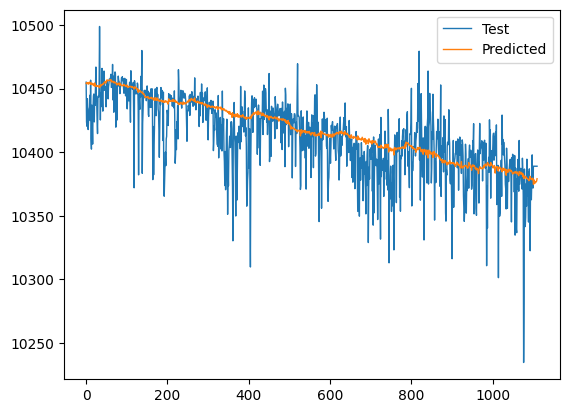

In [ ]:
plt.plot(actuals, label='Test', linewidth=1)
plt.plot(predictions, label='Predicted', linewidth=1)
plt.legend()
plt.show()

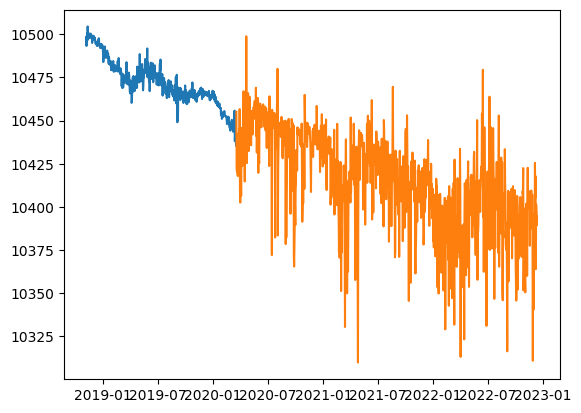

In [ ]:
plt.plot(df_train[-500:].ds, df_train[-500:].y)
plt.plot(df_test[:1000].ds, df_test[:1000].y)

In [ ]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(tuned_model))  # Save model